# Job configurations

We consider the following throughput computing scenario.
* Computations are done on a compute node with $P$ CPUs (cores) and with $M$ maximum memory.
* A total of $N$ independent computations has to be executed.
* Each of these computations takes equal time to execute.
* Each computation can be done using $p$ threads (or processes $\times$ threads), where $1 \le p \le P$.
* Each task requires at most $m \le M$ maximum memory.
* $n$ such computations can be done in parallel where $n \cdot p \le P$ and $n \cdot m \le M$.

Without loss of generality, we can set $N = P$.  In practice, $P$ is even, but not necessarily a power of 2.

The two most extreme job configurations are:
1. Run $P$ computations with $n = 1$ computations sequentially, using $p = P$ threads.
2. Run $P$ computations in parallel with $n = P$, using $p = 1$ thread for each.

However, many other job configurations are possible, e.g., run $P/2$ computations in parallel, using $p = 2$ threads for each, in 2 batches.  It is also important to realize that the nu not all the $P$ CPUs have to be used, i.e., $n \cdot p < P$ is a viable configuration, perhaps imposed by memory considerations or efficiency.

Below we will visualize the job configuration space.

## Requirements

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

## Node specification & scheduler

To make the concepts more concrete, we assume that
* $P = 96$
* $M = 248$

This corresponds roughly to a dual socket Sapphire Rapid 
To clarify the relation with the Slurm job scheduler:
* $p$ corresponds to `cpus-per-task`
* $n$ corresponds to `ntasks`

The mapping of the memory $m$ required for an individual computation is not so straightforward since Slurm provides only `mem-per-cpu`, not per task.  So $m$ corresponds to `cpus-per0-task` $\cdot$ `mem-per-cpu` in practice.

## Case 1: default memory requirements

In this case, memory is not a concern.  The memory required per domputation is such that $P$ computations fit into the total memory $M$ of the node.

In [51]:
ntasks = [1, 2, 4, 6, 8, 12, 18, 24, 32, 48, 60, 72, 96]
cpus_per_task = [1, 2, 4, 8, 12, 24, 48, 96]
nr_cpus = 96

In [52]:
configs = np.array([(n, p) for n, p in itertools.product(ntasks, cpus_per_task) if n*p <= nr_cpus]).transpose()

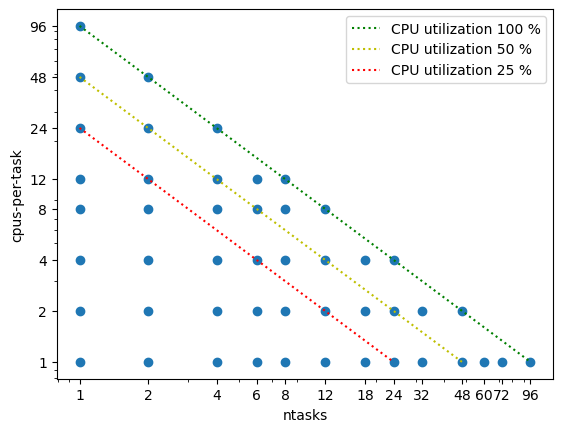

In [53]:
plt.loglog(configs[0, :], configs[1, :], 'o')
plt.xticks(ntasks, [str(n) for n in ntasks]);
plt.xlabel('ntasks');
plt.yticks(cpus_per_task, [str(p) for p in cpus_per_task]);
plt.ylabel('cpus-per-task');
plt.plot([1, 96], [96, 1], 'g:', label='CPU utilization 100 %')
plt.plot([1, 48], [48, 1], 'y:', label='CPU utilization 50 %')
plt.plot([1, 24], [24, 1], 'r:', label='CPU utilization 25 %')
plt.legend();

## Case 2: non-default memory requirements

In this case, the number of tasks $n$ that is run in parallel is limited by
$$
    n_{\mathrm{max}} = \left \lfloor \frac{M}{m} \right \rfloor
$$

In [66]:
ntasks = [1, 2, 4, 6, 8, 12, 18, 24, 32, 48, 60, 72, 96]
cpus_per_task = [1, 2, 4, 8, 12, 24, 48, 96]
nr_cpus = 96
max_mem = 248
m = 10
ntasks_max = max_mem//m
print(f'Maximum number of parallel tasks: {n_max}')

Maximum number of parallel tasks: 24


In [55]:
configs = np.array([(n, p) for n, p in itertools.product(ntasks, cpus_per_task) if n*p <= nr_cpus and n*m <= max_mem]).transpose()

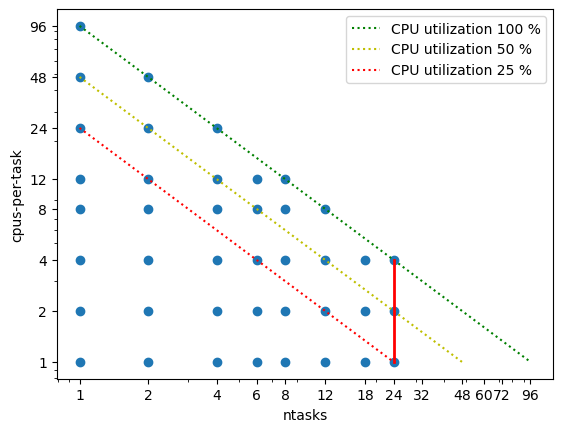

In [67]:
plt.loglog(configs[0, :], configs[1, :], 'o')
plt.xticks(ntasks, [str(n) for n in ntasks]);
plt.xlabel('ntasks');
plt.yticks(cpus_per_task, [str(p) for p in cpus_per_task]);
plt.ylabel('cpus-per-task');
plt.plot([1, 96], [96, 1], 'g:', label='CPU utilization 100 %')
plt.plot([1, 48], [48, 1], 'y:', label='CPU utilization 50 %')
plt.plot([1, 24], [24, 1], 'r:', label='CPU utilization 25 %')
plt.plot([ntasks_max, ntasks_max], [1, nr_cpus//ntasks_max], 'r', linewidth=2.0)
plt.legend();

It is clear that in this situation, the number of tasks $n$ that can be run on parallel is limited by the available memory in the node $M$.

## Measures

Although by itself the optimal configuration would be the one with the shortest runtime, it is also useful to quantify the efficiency.

The CPU utilization is given by
$$
    U(p, n) = \frac{n \cdot p}{P} \le 1
$$

Now the time to calculate all the $P$ computations using each of the configurations can be measured.  They are represented by $T(p, n)$, the time to perform $N =P$ computations using $n$ computations in parallel that each run with $p$ threads.

The base case is $T(1, 1)$, i.e., running the $N$ computation sequentially with $p = 1$.  The throughput speedup can now be defined as
$$
    S_{\mathrm{throughput}}(p, n) = \frac{T(1, 1)}{T(p, n)}
$$

The throughput efficiency can be defined as:
$$
    E_{\mathrm{throughput}}(p, n) = S_{\mathrm{throughput}}(p, n) \cdot U(p, n)
$$

The parallel speedup of a single computation is given by:
$$
    S(p, n) = \frac{T(1, 1)/P}{\frac{T(p, n)}{P/n}} = n \frac{T(1, 1)}{T(p, n)} = n \cdot S_{\mathrm{throughput}}(p, n)
$$

Hence the parallel efficiency of a single computation is:
$$
    E(p, n) = \frac{S(p, n)}{p} = \frac{n}{p} \cdot S_{\mathrm{throughput}}(p, n) = \frac{P}{p} E_{\mathrm{throughput}}(p, n)
$$

Note that $S(p, 1) = S_{\mathrm{throughput}}(p, 1)$ and $E(p, 1) = E_{\mathrm{throughput}}(p, 1)$ as expected.